# TF-IDF Cost Sensitive Loss

In [1]:
import time
import os
import pyhocon
import torch
import argparse
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import glob
import os, re, json
import matplotlib.pyplot as plt
import jsonlines
import random
import torch.nn.functional as F
import math
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')

+ データ処理
    + データのロード
    + データの前処理
    + データの分割
+ モデルの構築
    + Cmb Attentionモデル
    + 損失関数の定義
        + tf-idf形式のコスト損失関数の構築
        
+ モデルの訓練
    + モデルの学習
    + モデルの精度評価

## データ処理

### データのディレクトリを取得

In [3]:
data_url_repo = "data/corpus/*"
data_url_dir = glob.glob(data_url_repo)

In [4]:
EOS_token = '<EOS>'
BOS_token = '<BOS>'
file_pattern = re.compile(r'^sw\_([a-z]+?)\_([0-9]+?)\.jsonlines$')

swda_tagu = {
    '<Uninterpretable>': ['abandoned_or_turn-exit/uninterpretable', 'non-verbal'],
    '<Statement>': ['statement-non-opinion', 'statement-opinion', 'other_answers', '3rd-party-talk', 'self-talk', 'offers,_options_commits', 'collaborative_completion'],
    '<Question>': ['q', 'yes-no-question', 'wh-question', 'declarative_yes-no-question', 'backchannel_in_question_form', 'open-question', 'rhetorical-questions', 'signal-non-understanding', 'or-clause', 'tag-question', 'declarative_wh-question'],
    '<Directive>': ['action-directive'],
    '<Greeting>': ['conventional-opening', 'conventional-closing'],
    '<Apology>': ['apology', 'no_answers', 'reject', 'negative_non-no_answers', 'dispreferred_answers', 'dispreferred_answers'],
    '<Agreement>': ['agree/accept', 'maybe/accept-part', 'thanking'],
    '<Understanding>': ['acknowledge_(backchannel)', 'summarize/reformulate', 'appreciation', 'response_acknowledgement', 'affirmative_non-yes_answers', 'yes_answers'],
    '<Other>': ['other', 'hedge', 'quotation', 'repeat-phrase', 'hold_before_answer/agreement', 'downplayer']
}

daily_tagu = {1: "inform", 2: "question", 3: "directive", 4: "commissive"}

### 対話行為のID化

In [5]:
class DA_to_ID:
    
    def __init__(self, config, X_DA, Y_DA, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_DA = X_DA
        self.Y_DA = Y_DA
        self.name = name
        self.construct()
        
    def construct(self):
#        vocab = {'<PAD>': 0}
        vocab = {}
        vocab_count = {}
        
        for x,y in zip(self.X_DA, self.Y_DA):
            for token in x:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
            for token in y:
                if token in vocab_count:
                    vocab_count[token] += 1
                else:
                    vocab_count[token] = 1
                    
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}
        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        X_Tensor = [[self.word2id[token] for token in sentence] for sentence in X_tensor]
        Y_Tensor = [[self.word2id[token] for token in sentence] for sentence in Y_tensor]
        return X_Tensor, Y_Tensor

### 発話のID化

In [6]:
class UTT_to_ID:
    
    def __init__(self, config, X_UTT, Y_UTT, name):
        self.word2id = None
        self.id2word = None
        self.config = config
        self.X_UTT = X_UTT
        self.Y_UTT = Y_UTT
        self.name = name
        self.construct()
        
    def construct(self):
        
        vocab = {'<UNK>': 0, '<EOS>': 1, '<BOS>': 2, '<UttPAD>': 3, '<ConvPAD>': 4}
        vocab_count = {}
        
        for x,y in zip(self.X_UTT, self.Y_UTT):
            for seq in x:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
            for seq in y:
                for word in seq:
                    if word in vocab_count:
                        vocab_count[word] += 1
                    else:
                        vocab_count[word] = 1
                        
        for k, _ in sorted(vocab_count.items(), key=lambda x: -x[1]):
            vocab[k] = len(vocab)
            if len(vocab) >= self.config[self.name]['UTT_MAX_VOCAB']: break
        self.word2id = vocab
        self.id2word = {v : k for k, v in vocab.items()}

        return vocab
        
    def tokenize(self, X_tensor, Y_tensor):
        
        X_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in X_tensor]
        Y_Tensor = [[[self.word2id[token] if token in self.word2id else self.word2id['<UNK>'] for token in seq] for seq in dialogue] for dialogue in Y_tensor]
        return X_Tensor, Y_Tensor

### トレーニングデータ作成

In [7]:
def create_traindata(config, name):
    files = [f for f in os.listdir(config[name]['train_path']) if file_pattern.match(f)]
    # print("files:" , files)
    da_x, da_y, utt_x, utt_y, turn = [], [], [], [], []
    # 1file 1conversation
    for filename in files:
        # print(os.path.join(config['train_path'], filename))
        with open(os.path.join(config[name]['train_path'], filename), 'r') as f:
            data = f.read().split('\n')
            data.remove('')
            da_seq, utt_seq, turn_seq = [], [], []
            # 1line 1turn
            for idx, line in enumerate(data, 1):
                jsondata = json.loads(line)
                # single-turn multi dialogue case
                if config[name]['multi_dialogue']:
                    for da, utt in zip(jsondata['DA'], jsondata['sentence']):
                        da_seq.append(da)
                        utt_seq.append(utt.split(' '))
                        turn_seq.append(0)
                    if config[name]['turn']:
                        da_seq.append('<turn>')
                        utt_seq.append('<turn>')
                    turn_seq[-1] = 1
                # single-turn single dialogue case
                else:
                    da_seq.append(jsondata['DA'][-1])
                    utt_seq.append(jsondata['sentence'][-1].split(' '))
            da_seq = [easy_damsl(da) for da in da_seq]
        
            
            # assert len(turn_seq) == len(da_seq), '{} != {}'.format(len(turn_seq), len(da_seq))
        if config[name]['state']:
            for i in range(max(1, len(da_seq) - 1 - config[name]['window_size'])):
                da_x.append(da_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                da_y.append(da_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                utt_x.append(utt_seq[i:min(len(da_seq)-1, i + config[name]['window_size'])])
                utt_y.append(utt_seq[1 + i:min(len(da_seq), 1 + i + config[name]['window_size'])])
                turn.append(turn_seq[i:min(len(da_seq), i + config[name]['window_size'])])
        else:
            da_x.append(da_seq[:-1])
            da_y.append(da_seq[1:])
            utt_x.append(utt_seq[:-1])
            utt_y.append(utt_seq[1:])
            turn.append(turn_seq[:-1])
    assert len(da_x) == len(da_y), 'Unexpect length da_posts and da_cmnts'
    assert len(utt_x) == len(utt_y), 'Unexpect length utt_posts and utt_cmnts'
    # assert len(turn) == len(da_posts)
    
    return da_x, da_y, utt_x, utt_y, turn


### タグ

In [8]:
def easy_damsl(tag):
    easy_tag = [k for k, v in swda_tagu.items() if tag in v]
    return easy_tag[0] if not len(easy_tag) < 1 else tag

### データの分割

In [9]:
def separate_data(x, y, turn):
    split_size = round(len(x) / 10)
    if split_size == 0: split_size = 1
    X_train, Y_train, Tturn = x[split_size * 2:], y[split_size * 2:], turn[split_size * 2:]
    X_valid, Y_valid, Vturn = x[split_size: split_size * 2], y[split_size: split_size * 2], turn[split_size: split_size * 2]
    X_test, Y_test, Testturn = x[:split_size], y[:split_size], turn[:split_size]
    assert len(X_train) == len(Y_train), 'Unexpect to separate train data'
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn

### 訓練の準備

In [10]:
def initialize_env(name):
    config = pyhocon.ConfigFactory.parse_file('./dialogue.conf')
    config['log_dirs'] = os.path.join(config[name]['log_dir'])
    if not os.path.exists(config['log_dirs']):
        os.mkdir(config['log_dirs'])
     
    return config

In [11]:
def create_DAdata(config, name):
    posts, cmnts, _, _, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, Tturn, Vturn, Testturn

def create_Uttdata(config, name):
    _, _, posts, cmnts, turn = create_traindata(config, name)
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test, _, _, _ = separate_data(posts, cmnts, turn)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test


In [12]:
model_name = 'CmbAttention'
# loss_name = "Affinity"
loss_name = "CE"
# loss_name = "LogAll"
# loss_name = "CE_cost"
# loss_name = "TFIDF_AllAdd"
# loss_name = "TFIDF_Allweight"

In [13]:
write = SummaryWriter("./logs")
config = initialize_env(model_name+loss_name)

XDA_train, YDA_train, XDA_valid, YDA_valid, _, _, Tturn, Vturn, _ = create_DAdata(config, model_name+loss_name)
XUtt_train, YUtt_train, XUtt_valid, YUtt_valid, _, _ = create_Uttdata(config, model_name+loss_name)

DA_vocab = DA_to_ID(config, XDA_train+XDA_valid, YDA_train+YDA_valid, model_name+loss_name)
Utt_vocab = UTT_to_ID(config, XUtt_train+XUtt_valid, YUtt_train+YUtt_valid, model_name+loss_name)

XDA_train, YDA_train = DA_vocab.tokenize(XDA_train, YDA_train)
XDA_valid, YDA_valid = DA_vocab.tokenize(XDA_valid, YDA_valid)
XUtt_train, YUtt_train = Utt_vocab.tokenize(XUtt_train, YUtt_train)
XUtt_valid, YUtt_valid = Utt_vocab.tokenize(XUtt_valid, YUtt_valid)

print('Finish preparing dataset...')

Finish preparing dataset...


## モデルの構築

#### Cmb Attention

In [14]:
class CmbAttentionModel(nn.Module):
    
    def __init__(self, model_name, utt_vocab, da_vocab, config, device):
        super(CmbAttentionModel, self).__init__()
        
        self.utter_encoder = UtteraceEncoder(len(utt_vocab.word2id), config[model_name]['UTT_EMBED'], config[model_name]['UTT_HIDDEN'])

        self.context_encoder = RNNContextAwareEncoder(config[model_name]['CON_EMBED'], config[model_name]['CON_HIDDEN'])

        self.da_encoder = RNNDAAwareEncoder(len(utt_vocab.word2id), config[model_name]['DA_EMBED'], config[model_name]['DA_HIDDEN'])

        self.de_encoder = DenceEncoder(config[model_name]['DA_HIDDEN'] + config[model_name]['CON_HIDDEN'], config[model_name]['DA_EMBED'], len(da_vocab.word2id))

        self.device = device
        
    def forward(self, X_utter, X_da, Y_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)
        
        Y_da = Y_da.squeeze()
        
        return output, utter_hidden, context_hidden, da_hidden
    
    def validtion(self, X_utter, X_da, Y_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)
            
        Y_da = Y_da.squeeze(0)

        return output, utter_hidden, context_hidden, da_hidden, Y_da


    def prediction(self, X_utter, X_da, mask, utter_hidden, context_hidden, da_hidden, turn):

        utter_output, utter_weights = self.utter_encoder(X_utter, mask)

        turn_output = torch.cat((utter_output, turn), dim=2)

        context_output, context_weights, context_hidden = self.context_encoder(turn_output, mask, context_hidden)

        da_output, da_weights, da_hidden = self.da_encoder(X_da, mask, da_hidden)

        x_output = torch.cat((context_output, da_output), dim=2)

        dence_output = self.de_encoder(x_output)

        output = dence_output.squeeze(1)  # (batch_size, da_dim)

        return output, utter_hidden, context_hidden, da_hidden, utter_weights


    def initDAHidden(self, batch_size):
        return self.utter_encoder.initHidden(batch_size, self.device), self.context_encoder.initHidden(batch_size, self.device), self.da_encoder.initHidden(batch_size, self.device)

#### Model Block

In [15]:
class WordEmbedding(nn.Module):

    def __init__(self, vocab_size, embed_size, w_model):
        super(WordEmbedding, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, w_model)

    def forward(self, x_word):
        return torch.tanh(self.linear(self.word_embedding(x_word)))

In [16]:
class DAEmbedding(nn.Module):

    def __init__(self, da_size, embed_size, d_model):
        super(DAEmbedding, self).__init__()
        self.da_embedding = nn.Embedding(da_size, embed_size)
        self.linear = nn.Linear(embed_size, d_model)

    def forward(self, x_da):
        return torch.tanh(self.linear(self.da_embedding(x_da)))

In [17]:
class Attention(nn.Module):

    def __init__(self, d_model):
        super(Attention, self).__init__()
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.d_k = d_model
       
    def forward(self, q, k, v, mask=None):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)
        
        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        attention_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(attention_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, attention_weights

In [18]:
class ContextAttention(nn.Module):

    def __init__(self, d_model, hidden_size, att_size):
        super(ContextAttention, self).__init__()
        self.q_linear = nn.Linear(att_size, att_size)
        self.v_linear = nn.Linear(att_size, att_size)
        self.k_linear = nn.Linear(att_size, att_size)

        self.fc_1 = nn.Linear(d_model, d_model)
        self.fc_3 = nn.Linear(hidden_size, d_model, bias=True)
        self.fc_2 = nn.Linear(d_model, att_size)

        self.fc_out = nn.Linear(att_size, hidden_size, bias=True)
        self.d_k = att_size

    def forward(self, x, mask, hidden):
        
        x = self.fc_2(torch.tanh(self.fc_1(x) + self.fc_3(hidden)))

        q = self.q_linear(x)
        v = self.v_linear(x)
        k = self.k_linear(x)

        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        if mask is not None:
            mask = mask.unsqueeze(1)
            weights = weights.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(weights, dim=-1)

        att_output = torch.matmul(attention_weights, v)

        output = self.fc_out(att_output)

        return output, attention_weights

In [19]:
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):

        x = self.linear_1(x)

        x = self.dropout(F.relu(x))

        x = self.linear_2(x)

        return x

In [20]:
class PositinalEncoding(nn.Module):

    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositinalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)


In [21]:
class DenceEncoder(nn.Module):
    def __init__(self, da_hidden, da_embed_size, da_input_size):
        super(DenceEncoder, self).__init__()
        self.he = nn.Linear(da_hidden, da_embed_size)
        self.ey = nn.Linear(da_embed_size, da_input_size)

    def forward(self, hidden):
        pred = self.ey(torch.tanh(self.he(hidden)))
        return pred


In [22]:
class RNNContextAwareEncoder(nn.Module):
    
    def __init__(self, emb_dim, d_model):
        super(RNNContextAwareEncoder, self).__init__()
        self.d_model = d_model
        self.linear = nn.Linear(self.d_model+1, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, self.d_model)

    def forward(self, x, mask, hidden):

        lin_output = self.linear(x)

        att_output, att_weights = self.attention(lin_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [23]:
class RNNDAAwareEncoder(nn.Module):

    def __init__(self, da_size, emb_dim, d_model):
        super(RNNDAAwareEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = DAEmbedding(da_size, emb_dim, self.d_model)
        self.rnn = nn.GRU(self.d_model, self.d_model, batch_first=True)
        self.attention = ContextAttention(self.d_model, self.d_model, self.d_model)
        self.ffn = FeedForward(self.d_model, emb_dim)

    def forward(self, X_da, mask, hidden):

        emb_output = self.embedding(X_da)

        att_output, att_weights = self.attention(emb_output, mask, hidden.transpose(0,1))        

        rnn_output, rnn_hidden = self.rnn(att_output, hidden)

        ffn_output = self.ffn(rnn_output)

        return ffn_output, att_weights, rnn_hidden

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

In [24]:
class UtteraceEncoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, d_model):
        super(UtteraceEncoder, self).__init__()
        self.d_model = d_model
        self.embedding = WordEmbedding(vocab_size, emb_dim, self.d_model)
        self.pe = PositinalEncoding(self.d_model, 200)
        self.att = Attention(self.d_model)
        self.ffn = FeedForward(d_model, emb_dim)
        
    def forward(self, x_utter, mask):

        emb_output = self.embedding(x_utter)

        pos_output = self.pe(emb_output)

        att_output, att_weights = self.att(pos_output, pos_output, pos_output, mask)

        ffn_output = self.ffn(att_output)

        seq_len = ffn_output.size()[1]

        avg_output = F.avg_pool2d(ffn_output, (seq_len, 1)) # => (128, 1, 512)

        return avg_output, att_weights  # 発話ベクトル(128, 1, 512)

    def initHidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.d_model).to(device)

### TF-IDF Loss Fcuntion

In [25]:
class AllDataTFIDF(nn.Module):
    def __init__(self, tfidf, device):
        super(AllDataTFIDF, self).__init__()
        self.tfidf = tfidf
        self.ce = nn.CrossEntropyLoss(reduction='mean')
        self.device = device
        
    def forward(self, logit, target):
        ce_loss = self.ce(logit, target)
        pred = torch.argmax(logit.squeeze(1), dim=1).to(self.device)
        cost_loss = Add_tfidf_cost(pred, target.to(self.device), self.tfidf)
        return ce_loss + torch.tensor(cost_loss)
    
def Add_tfidf_cost(pred, target, tfidf):
    loss=[0]
    for i, p in enumerate(pred):
        if target[i]!=p:
            loss.append(tfidf[target[i]])
    return np.array(loss).mean()

#### TF-IDF ALL 

In [26]:
TFIDF_Allweight=[
    0.008819631900111391,
    0.0848148499389655,
    0.2120586174920262,
    0.3158002502173657,
    0.4848457517317563,
    0.7863592650818836,
    1.2701063502450178,
    0.9210760201244663,
    1.0213459579190332
]
TFIDF_Allweights=torch.tensor(TFIDF_Allweight, dtype=torch.float32)

### Cost Sensitive Loss (割合重視)　=> Cost Matrix

In [27]:
class_matrix = [
    [0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
    [0.6606467194974978, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
    [1.4345745909708165, 0.7739278714733187, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
    [2.0795002276998646, 1.418853508202367, 0.6449256367290482, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01],
    [2.927104615492692, 2.2664578959951944, 1.4925300245218756, 0.8476043877928274, 0.0, 0.01, 0.01, 0.01, 0.01],
    [4.628593334154884, 3.9679466146573863, 3.1940187431840674, 2.549093106455019, 1.7014887186621916, 0.0, 0.01, 0.01, 0.01],
    [5.2347708574106395, 4.574124137913142, 3.800196266439823, 3.1552706297107744, 2.3076662419179472, 0.6061775232557551, 0.0, 0.01, 0.01],
    [5.372836213185386, 4.712189493687888, 3.9382616222145694, 3.293335985485521, 2.4457315976926934, 0.7442428790305019, 0.13806535577474677,
  0.0, 0.01],
    [5.663684515195216, 5.003037795697718, 4.2291099242243995, 3.5841842874953516, 2.7365798997025244, 1.0350911810403323, 0.4289136577845772,
  0.2908483020098305, 0.0]
]

In [28]:
class CostMatrixLoss(nn.Module):
    def __init__(self, device, cost_matrix):
        super(CostMatrixLoss, self).__init__()
        self.loss_ = nn.CrossEntropyLoss(reduction='none')
        self.cost_matrix = cost_matrix
        
    def forward(self, logit, target):
        ce_output = self.loss_(logit, target)
        ce_output = torch.unsqueeze(ce_output,0)
        pred = torch.argmax(logit.squeeze(1), dim=1)
        cost_mat = torch.tensor([self.cost_matrix[target[i]][pred[i]] for i in range(len(pred))])
        cost_output = torch.matmul(ce_output, cost_mat)
        return cost_output/len(pred)

### Class Weight: log(全体/タグ数)

In [30]:
class_log_all_weight = [
    0.6711497989840916,
    1.3317965184815894,
    2.105724389954908,
    2.750650026683956,
    3.598254414476784,
    5.299743133138976,
    5.905920656394731,
    6.043986012169477,
    6.334834314179308
]
class_log_all_weights = torch.tensor(class_log_all_weight, dtype=torch.float32)

### モデルの選択

In [31]:
def select_model(mode_name, utt_vocab, da_vocab, config, device, lr, loss_func):
    
    if model_name == "CmbAttention":
        
        if loss_func == "CE":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = nn.CrossEntropyLoss(reduction='mean', weight=torch.tensor([1.0, 1.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]).cuda())
        
        elif loss_func == "Affinity":
            model = CmbAttentionModel_affinity(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = Affinity_Loss(0.95, len(da_vocab.word2id), device)
            
        elif loss_func == "LogAll":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = nn.CrossEntropyLoss(reduction='mean', weight=class_log_all_weights).to(device)
            
        elif loss_func == "TFIDF_Allweight":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = nn.CrossEntropyLoss(reduction='mean', weight=TFIDF_Allweights).to(device)
            
        elif loss_func == "CE_cost":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = CostMatrixLoss(device, class_matrix)
            
        elif loss_func == "TFIDF_AllAdd":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = AllDataTFIDF(TFIDF_Allweight, device).to(device)
            
        elif loss_func == "TFIDF_Update":
            model = CmbAttentionModel(model_name+loss_func, utt_vocab, da_vocab, config, device).to(device)
            opt = optim.Adam(model.parameters(), lr)
            loss_function = AllDataTFIDF(TFIDF_Allweight, device).to(device)
    else:
        model = None
        opt = None
        loss_function = None
        
    return model, opt, loss_function

In [32]:
# device = torch.device('cuda:0')

# loss_name = "Affinity"
# loss_name = "CE"
# loss_name = "LogAll"
loss_name = "CE_cost"
# loss_name = "TFIDF_AllAdd"
# loss_name = "TFIDF_Allweight"

In [33]:
lr = config[model_name+loss_name]['lr']
batch_size = config[model_name+loss_name]['BATCH_SIZE']
plot_train_losses = []
plot_valid_losses = []
    
print_total_loss = 0
plot_total_loss = 0
plot_total_acc = 0
_valid_loss = None

models, optims, loss_func = select_model(model_name, Utt_vocab, DA_vocab, config, device, lr, loss_name)   

## モデルの訓練

#### 検証

In [34]:
@torch.no_grad()
def validation(X_valid, Y_valid, XU_valid, YU_valid, model, device, config, turn):

    total_loss = 0
    idx = 0
    
    for seq_idx in range(len(X_valid)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(X_valid)), end='')
        utter_hidden, context_hidden, da_hidden = model.initDAHidden(1)
        X_seq = X_valid[seq_idx]
        Y_seq = Y_valid[seq_idx]
        turn[seq_idx] = turn[seq_idx] + [0] * (len(X_seq) - len(turn[seq_idx]))
        turn_seq = turn[seq_idx]
        XU_seq = XU_valid[seq_idx]
        YU_seq = YU_valid[seq_idx]

        assert len(X_seq) == len(Y_seq), 'Unexpect sequence len in evaluate {} != {}'.format(len(X_seq), len(Y_seq))
        
        for i in range(0, len(X_seq)):
            X_tensor = torch.tensor([[X_seq[i]]]).to(device)
            Y_tensor = torch.tensor([[Y_seq[i]]]).to(device)
            turn_tensor = torch.tensor([[turn_seq[i]]]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)   
            XU_tensor = torch.tensor([XU_seq[i]]).to(device)
            
            output, utter_hidden, context_hidden, da_hidden, Y_tensor = model.validtion(XU_tensor, X_tensor, Y_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)
            loss = loss_func(output, Y_tensor)
            total_loss += loss.item()
            
        total_loss/=5

    return total_loss

In [35]:
# validation(XDA_valid, YDA_valid, XUtt_valid, YUtt_valid, models, device, config, Vturn)

#### 訓練

In [36]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [37]:
print('{} start TRAINING'.format(model_name+loss_name))

start = time.time()

config[model_name+loss_name]['EPOCH'] = 30

for epoch in range(config[model_name+loss_name]['EPOCH']):
    
    tmp_time = time.time()
    print('Epoch {} start'.format(epoch+1))
    index = [i for i in range(len(XDA_train))]
    random.shuffle(index)
    idx=0
    
    while idx < len(index):
        step_size = min(batch_size, len(index)-idx)
        batch_idx = index[idx:idx+step_size]
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(step_size)
        
        print('\rConversation {}/{} training...'.format(idx + step_size, len(XDA_train)), end='')
        Xda_seq = [XDA_train[seq_idx] for seq_idx in batch_idx]
        Yda_seq = [YDA_train[seq_idx] for seq_idx in batch_idx]
        turn_seq = [Tturn[seq_idx] for seq_idx in batch_idx]
        max_conv_len = max(len(s) for s in Xda_seq) 
        
        ## 
        XUtt_seq = [XUtt_train[seq_idx] for seq_idx in batch_idx]
        YUtt_seq = [YUtt_train[seq_idx] for seq_idx in batch_idx]
            
        for i in range(len(XUtt_seq)):
            XUtt_seq[i] = XUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(XUtt_seq[i]))
            YUtt_seq[i] = YUtt_seq[i] + [[Utt_vocab.word2id['<ConvPAD>']]] * (max_conv_len - len(YUtt_seq[i]))
                
        for ci in range(len(Xda_seq)):

            turn_seq[ci] = turn_seq[ci] + [0] * (max_conv_len - len(turn_seq[ci]))
            Xda_seq[ci] = Xda_seq[ci] + [-1] * (max_conv_len - len(Xda_seq[ci]))
            Yda_seq[ci] = Yda_seq[ci] + [-1] * (max_conv_len - len(Yda_seq[ci]))
            
        for i in range(0, max_conv_len):
            last = True if i == max_conv_len - 1 else False
            
            Xda_tensor = torch.tensor([[X[i]] for X in Xda_seq]).to(device)
            Yda_tensor = torch.tensor([[Y[i]] for Y in Yda_seq]).to(device)
            turn_tensor = torch.tensor([[t[i]] for t in turn_seq]).to(device)
            turn_tensor = turn_tensor.float()
            turn_tensor = turn_tensor.unsqueeze(1)    
                
            max_seq_len = max(len(XU[i]) + 1 for XU in XUtt_seq)
            for ci in range(len(XUtt_seq)):
                XUtt_seq[ci][i] = XUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(XUtt_seq[ci][i]))
                YUtt_seq[ci][i] = YUtt_seq[ci][i] + [Utt_vocab.word2id['<UttPAD>']] * (max_seq_len - len(YUtt_seq[ci][i]))
            XUtt_tensor = torch.tensor([XU[i] for XU in XUtt_seq]).to(device)
            YUtt_tensor = None

            output, utter_hidden, context_hidden, da_hidden = models(XUtt_tensor, Xda_tensor, Yda_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)
            Yda_tensor=Yda_tensor.squeeze(1)
            loss = loss_func(output.to(device), Yda_tensor.to(device)).to(device)
            optims.zero_grad()
            loss.backward(retain_graph=True)
            print_total_loss += loss.item()
                
            if last:
                optims.step()
        print_total_loss/=max_conv_len  
        
        idx += step_size
        
    valid_loss = validation(XDA_valid, YDA_valid, XUtt_valid, YUtt_valid, models, device, config, Vturn)
    
    
    def save_model(filename):
        torch.save(models.state_dict(), os.path.join(config[model_name+loss_name]['log_dir'], config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + ".model".format(filename)))
        
    print("steps %d\tloss %.4f\tvalid loss %.4f | exec time %.4f" % (epoch+1, print_total_loss, valid_loss, time.time()-tmp_time))
    print_total_loss = 0
    
    if _valid_loss == None:
        save_model("model_save")
        print("Model Saved")
        _valid_loss = valid_loss
    else:
        if valid_loss<_valid_loss:
            _valid_loss = valid_loss
            save_model("model_save")
            print("Model Saved")
            

CmbAttentionCE_cost start TRAINING
Epoch 1 start
20004/20004 conversation evaluating...steps 1	loss 0.0667	valid loss 1.7066 | exec time 397.5827
Model Saved
Epoch 2 start
20004/20004 conversation evaluatingsteps 2	loss 0.1351	valid loss 2.4451 | exec time 614.7333
Epoch 3 start
20004/20004 conversation evaluatingsteps 3	loss 0.0912	valid loss 1.6205 | exec time 646.5804
Model Saved
Epoch 4 start
20004/20004 conversation evaluatingsteps 4	loss 0.2143	valid loss 1.2417 | exec time 599.2385
Model Saved
Epoch 5 start
20004/20004 conversation evaluatingsteps 5	loss 0.0370	valid loss 1.1879 | exec time 556.8778
Model Saved
Epoch 6 start
20004/20004 conversation evaluatingsteps 6	loss 0.0290	valid loss 1.1924 | exec time 641.9503
Epoch 7 start
20004/20004 conversation evaluatingsteps 7	loss 0.0794	valid loss 1.6472 | exec time 648.4370
Epoch 8 start
20004/20004 conversation evaluatingsteps 8	loss 0.0821	valid loss 1.2769 | exec time 646.5317
Epoch 9 start
20004/20004 conversation evaluatings

### モデル評価

In [38]:
_, _, _, _, XDA_test, YDA_test, _, _, DAturn = create_DAdata(config, model_name+loss_name)
_, _, _, _, XUtt_test, YUtt_test = create_Uttdata(config, model_name+loss_name)

XDA_test, YDA_test = DA_vocab.tokenize(XDA_test, YDA_test)
XUtt_test, _ = Utt_vocab.tokenize(XUtt_test, YUtt_test)

print('tokenizer finish')

tokenizer finish


In [82]:
# loss_name = "Affinity"
# loss_name = "CE"
# loss_name = "LogAll"
loss_name = "CE_cost"
# loss_name = "TFIDF_AllAdd"
# loss_name = "TFIDF_Allweight"

In [83]:
models, _, _ = select_model(model_name, Utt_vocab, DA_vocab, config, device, lr, loss_name)
models.load_state_dict(torch.load(os.path.join(config[model_name+loss_name]['log_dir'], config[model_name+loss_name]['SAVE_NAME'] + "_" + str(config[model_name+loss_name]['window_size']) + ".model".format('model_save'))))

print('model loaded')

model loaded


In [40]:
@torch.no_grad()

def ModelTest():
    result=[]
    for seq_idx in range(0, len(XDA_test)):
        print('\r{}/{} conversation evaluating'.format(seq_idx+1, len(XDA_test)), end='')
        XDA_seq = XDA_test[seq_idx]
        YDA_seq = YDA_test[seq_idx]
        DAturn[seq_idx] = DAturn[seq_idx] + [0] * (len(XDA_seq) - len(DAturn[seq_idx]))
        DAturn_seq = DAturn[seq_idx]
        XUtt_seq = XUtt_test[seq_idx]

        pred_seq = []
        true_seq = []
        utter_hidden, context_hidden, da_hidden = models.initDAHidden(1)

        for i in range(0, len(XDA_seq)):
            XDA_tensor = torch.tensor([[XDA_seq[i]]]).to(device)
            YDA_tensor = torch.tensor(YDA_seq[i]).to(device)
            DAturn_tensor = torch.tensor([[DAturn_seq[i]]]).to(device)
            DAturn_tensor = DAturn_tensor.float()
            DAturn_tensor = DAturn_tensor.unsqueeze(1)
            XUtt_tensor = torch.tensor([XUtt_seq[i]]).to(device)

            output, utter_hidden, context_hidden, da_hidden, att_weights = models.prediction(XUtt_tensor, XDA_tensor, None, utter_hidden, context_hidden, da_hidden, DAturn_tensor)
                # output, utter_hidden, context_hidden, da_hidden = da_predict_model.prediction(XU_tensor, X_tensor, None, utter_hidden, context_hidden, da_hidden, turn_tensor)

            pred_idx = torch.argmax(output)
            pred_seq.append(pred_idx.item())
            true_seq.append(YDA_tensor.item())
            utter_list = [Utt_vocab.id2word[word] for word in XUtt_seq[i]]

        result.append({'true': true_seq,
                        'true_detok': [DA_vocab.id2word[token] for token in true_seq],
                        'pred': pred_seq,
                        'pred_detok': [DA_vocab.id2word[token] for token in pred_seq],
                        'UttSeq': [[Utt_vocab.id2word[word] for word in sentence] for sentence in XUtt_seq],
                        'seq_detok': [DA_vocab.id2word[label] for label in XDA_seq]})
    return result

In [41]:
def calc_average(y_true, y_pred):
    p = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    r = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    f = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    print('p: {} | r: {} | f: {} | acc: {}'.format(p, r, f, acc))

In [84]:
print(model_name+loss_name)
result = ModelTest()

CmbAttentionCE_cost
20004/20004 conversation evaluating

In [85]:
true = [label for line in result for label in line['true']]
pred = [label for line in result for label in line['pred']]

calc_average(y_true=true, y_pred=pred)
f = f1_score(y_true=true, y_pred=pred, average=None)
r = recall_score(y_true=true, y_pred=pred, average=None)
p = precision_score(y_true=true, y_pred=pred, average=None)

p: 0.12361455507656377 | r: 0.15890091206425622 | f: 0.024939540718547027 | acc: 0.03995200959808038


調査結果 (weight操作あり(多数派1, 少数派2.5))
+ CE weight
    + p: 0.24818453133519863 | r: 0.20607521870644477 | f: 0.20802163700276752 | acc: 0.5632773445310938
    + Statement> 0.71834421195035
    + Understanding> 0.5381366307541626
    + Uninterpretable> 0.19706556625401192
    + Question> 0.024621480118862317
    + Agreement> 0.059600614439324115
    + Apology> 0.0
    + Greeting> 0.33442622950819667
    + Other> 0.0
    + Directive> 0.0
    
    + p: 0.2208616507361535 | r: 0.20739232257066276 | f: 0.20530872105709908 | acc: 0.5402319536092781
    + Statement> 0.713659725208346
    + Understanding> 0.5119440279860069
    + Uninterpretable> 0.23632643151943952
    + Question> 0.04073820915926179
    + Agreement> 0.08844765342960288
    + Apology> 0.05831533477321814
    + Greeting> 0.19834710743801653
    + Other> 0.0
    + Directive> 0.0
    
    + p: 0.22583136491006917 | r: 0.20164583940949257 | f: 0.19933769306971447 | acc: 0.5272445510897821
    + Statement> 0.7129001270490534
    + Understanding> 0.489025049558479
    + Uninterpretable> 0.24705947625388372
    + Question> 0.01017050553395154
    + Agreement> 0.0694519804666305
    + Apology> 0.0
    + Greeting> 0.2654320987654321
    + Other> 0.0
    + Directive> 0.0

#### CE_cost (Cost Matrix)
1回目
+ p: 0.19701369707289088 
+ r: 0.18496287108708176 
+ f: 0.16902785521707672 
+ acc: 0.5407718456308738
+ Statement> 0.6820972495088409
+ Understanding> 0.5250899257634123
+ Uninterpretable> 0.019918246005202526
+ Question> 0.0
+ Agreement> 0.0014571948998178506
+ Apology> 0.0
+ Greeting> 0.28571428571428575
+ Other> 0.0
+ Directive> 0.0

2回目
+ p: 0.20648173193318442 
+ r: 0.1874203755705327 
+ f: 0.17165307997135495 
+ acc: 0.5417316536692661
+ Statement> 0.6833902603644694
+ Understanding> 0.5254842908552615
+ Uninterpretable> 0.019365410397735736
+ Question> 0.0
+ Agreement> 0.0029122679286494356
+ Apology> 0.0
+ Greeting> 0.3137254901960784
+ Other> 0.0
+ Directive> 0.0

3回目
+ p: 0.19553881707447446 
+ r: 0.1842547378287682 
+ f: 0.16758062586436398 
+ acc: 0.5416616676664667
+ Statement> 0.6831065179576384
+ Understanding> 0.5259693037853561
+ Uninterpretable> 0.020653789004457652
+ Question> 0.0
+ Agreement> 0.0021802325581395353
+ Apology> 0.0
+ Greeting> 0.2763157894736842
+ Other> 0.0
+ Directive> 0.0

### TF-IDF ADD

1回目
+ p: 0.24024057427900639 
+ r: 0.19567713365528064 
+ f: 0.1841594871204228 
+ acc: 0.5776944611077784

2回目
+ p: 0.24339163384492135 
+ r: 0.197476632150292 
+ f: 0.1860118815380931 
+ acc: 0.5782843431313738

3回目
+ p: 0.24072101610115867 
+ r: 0.1976486300940167 
+ f: 0.18606180160630123 
+ acc: 0.5775844831033793

In [62]:
[print(DA_vocab.id2word[idx], score) for idx, score in zip(sorted(set(true)),f)]

<Statement> 0.7132796365138373
<Understanding> 0.4894379513407409
<Uninterpretable> 0.2484285475885854
<Question> 0.011945647304763328
<Agreement> 0.06805293005671079
<Apology> 0.0
<Greeting> 0.24691358024691357
<Other> 0.0
<Directive> 0.0


[None, None, None, None, None, None, None, None, None]

### CE (1,2.0)
#### 1回目
+ p: 0.22455738479581544 
+ r: 0.20031668564795505 
+ f: 0.19756203256128346 
+ acc: 0.527874425114977
#### 2回目
+ p: 0.22495046951893624 
+ r: 0.1995043147984645 
+ f: 0.1973387287588854 
+ acc: 0.5272045590881823
#### 3回目
+ p: 0.22685003296671388 
+ r: 0.20040296203496163 
+ f: 0.19859147873288163 
+ acc: 0.5268946210757849



#### F-score
+ Statement> 0.7132796365138373
+ Understanding> 0.4894379513407409
+ Uninterpretable> 0.2484285475885854
+ Question> 0.011945647304763328
+ Agreement> 0.06805293005671079
+ Apology> 0.0
+ Greeting> 0.24691358024691357
+ Other> 0.0
+ Directive> 0.0
#### Recall
+ Statement> 0.6741952485993714
+ Understanding> 0.5211105571959965
+ Uninterpretable> 0.3608014218775246
+ Question> 0.0062276194924490115
+ Agreement> 0.04634056638470026
+ Apology> 0.0
+ Greeting> 0.1941747572815534
+ Other> 0.0
+ Directive> 0.0

### LogAll
+ p: 0.22366663225067787 
+ r: 0.2289095697286461 
+ f: 0.21175668482817597 
+ acc: 0.5251349730053989

+ Statement> 0.5828762176196146
+ Understanding> 0.7913870460559114
+ Uninterpretable> 0.11076102762966554
+ Question> 0.0535575276350615
+ Agreement> 0.061051857300478116
+ Apology> 0.16443594646271512
+ Greeting> 0.2961165048543689
+ Other> 0.0
+ Directive> 0.0

+ p: 0.22449542189480265 
+ r: 0.2272148944899485 
+ f: 0.21171216641043833 
+ acc: 0.5252249550089982

+ p: 0.22382434825256262 
+ r: 0.22902392483260078 
+ f: 0.21174164927044187 
+ acc: 0.5255048990201959

### TFIDF-all Add
+ p: 0.23289269243585706 
+ r: 0.19465300793384677 
+ f: 0.182717083718074 
+ acc: 0.5775144971005799

### TF-IDF weight

+ p: 0.09689848389010275 
+ r: 0.23841193688235723 
+ f: 0.12855223355309808 
+ acc: 0.20227954409118176

+ p: 0.09676394159233768 
+ r: 0.23825317197554727 
+ f: 0.12840115908452857 
+ acc: 0.2020895820835833

+ Statement> 0.0
+ Understanding> 0.5070368523986655
+ Uninterpretable> 0.4105671352399418
+ Question> 0.18511598941304686
+ Agreement> 0.13166605369621184
+ Apology> 0.5506692160611855
+ Greeting> 0.3592233009708738
+ Other> 0.0
+ Directive> 0.0

### Cost Matrix
#### 1回目
+ p: 0.12080379598662098 
+ r: 0.1531341742689922 
+ f: 0.023941154095175644 
+ acc: 0.040281943611277744

#### 2回目
+ p: 0.13763483434608195 
+ r: 0.157631517691455 
+ f: 0.024212401702408053 
+ acc: 0.040061987602479504

#### 3回目
+ p: 0.11920699267692308 
+ r: 0.15660119618604323 
+ f: 0.02429557269202011 
+ acc: 0.040561887622475506

#### 各タグのF-Score
+ Statement> 0.0631493326431767
+ Understanding> 0.0008426535927685
+ Uninterpretable> 0.004907781207947439
+ Question> 0.026620524424331164
+ Agreement> 0.05690400283386469
+ Apology> 0.028936170212765955
+ Greeting> 0.009816339455351488
+ Other> 0.006937731020756326
+ Directive> 0.01979707993071022

#### 各タグのRecall
+ Statement> 0.03453257071466219
+ Understanding> 0.0003451317252751467
+ Uninterpretable> 0.0025044433672645017
+ Question> 0.015569048731122529
+ Agreement> 0.7359323280617874
+ Apology> 0.032504780114722756
+ Greeting> 0.15048543689320387
+ Other> 0.2890995260663507
+ Directive> 0.1484375

### Create Image (Confusion_Matrix)

In [77]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
def save_cmx(y_true, y_pred, loss_name):
    fontsize = 40
    labels = [DA_vocab.id2word[idx] for idx in sorted(list(set(y_true)))]
    y_true_list = [DA_vocab.id2word[idx] for idx in y_true]
    y_pred_list = [DA_vocab.id2word[idx] for idx in y_pred]
    
    cmx_data = confusion_matrix(y_true_list, y_pred_list, labels=labels, normalize='true')

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize=(40, 30))
    plt.rcParams['font.size'] = fontsize
    heatmap = sns.heatmap(df_cmx, annot=True, fmt='.4f', cmap='Blues')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('./data/images/cmx_{}.png'.format(loss_name))


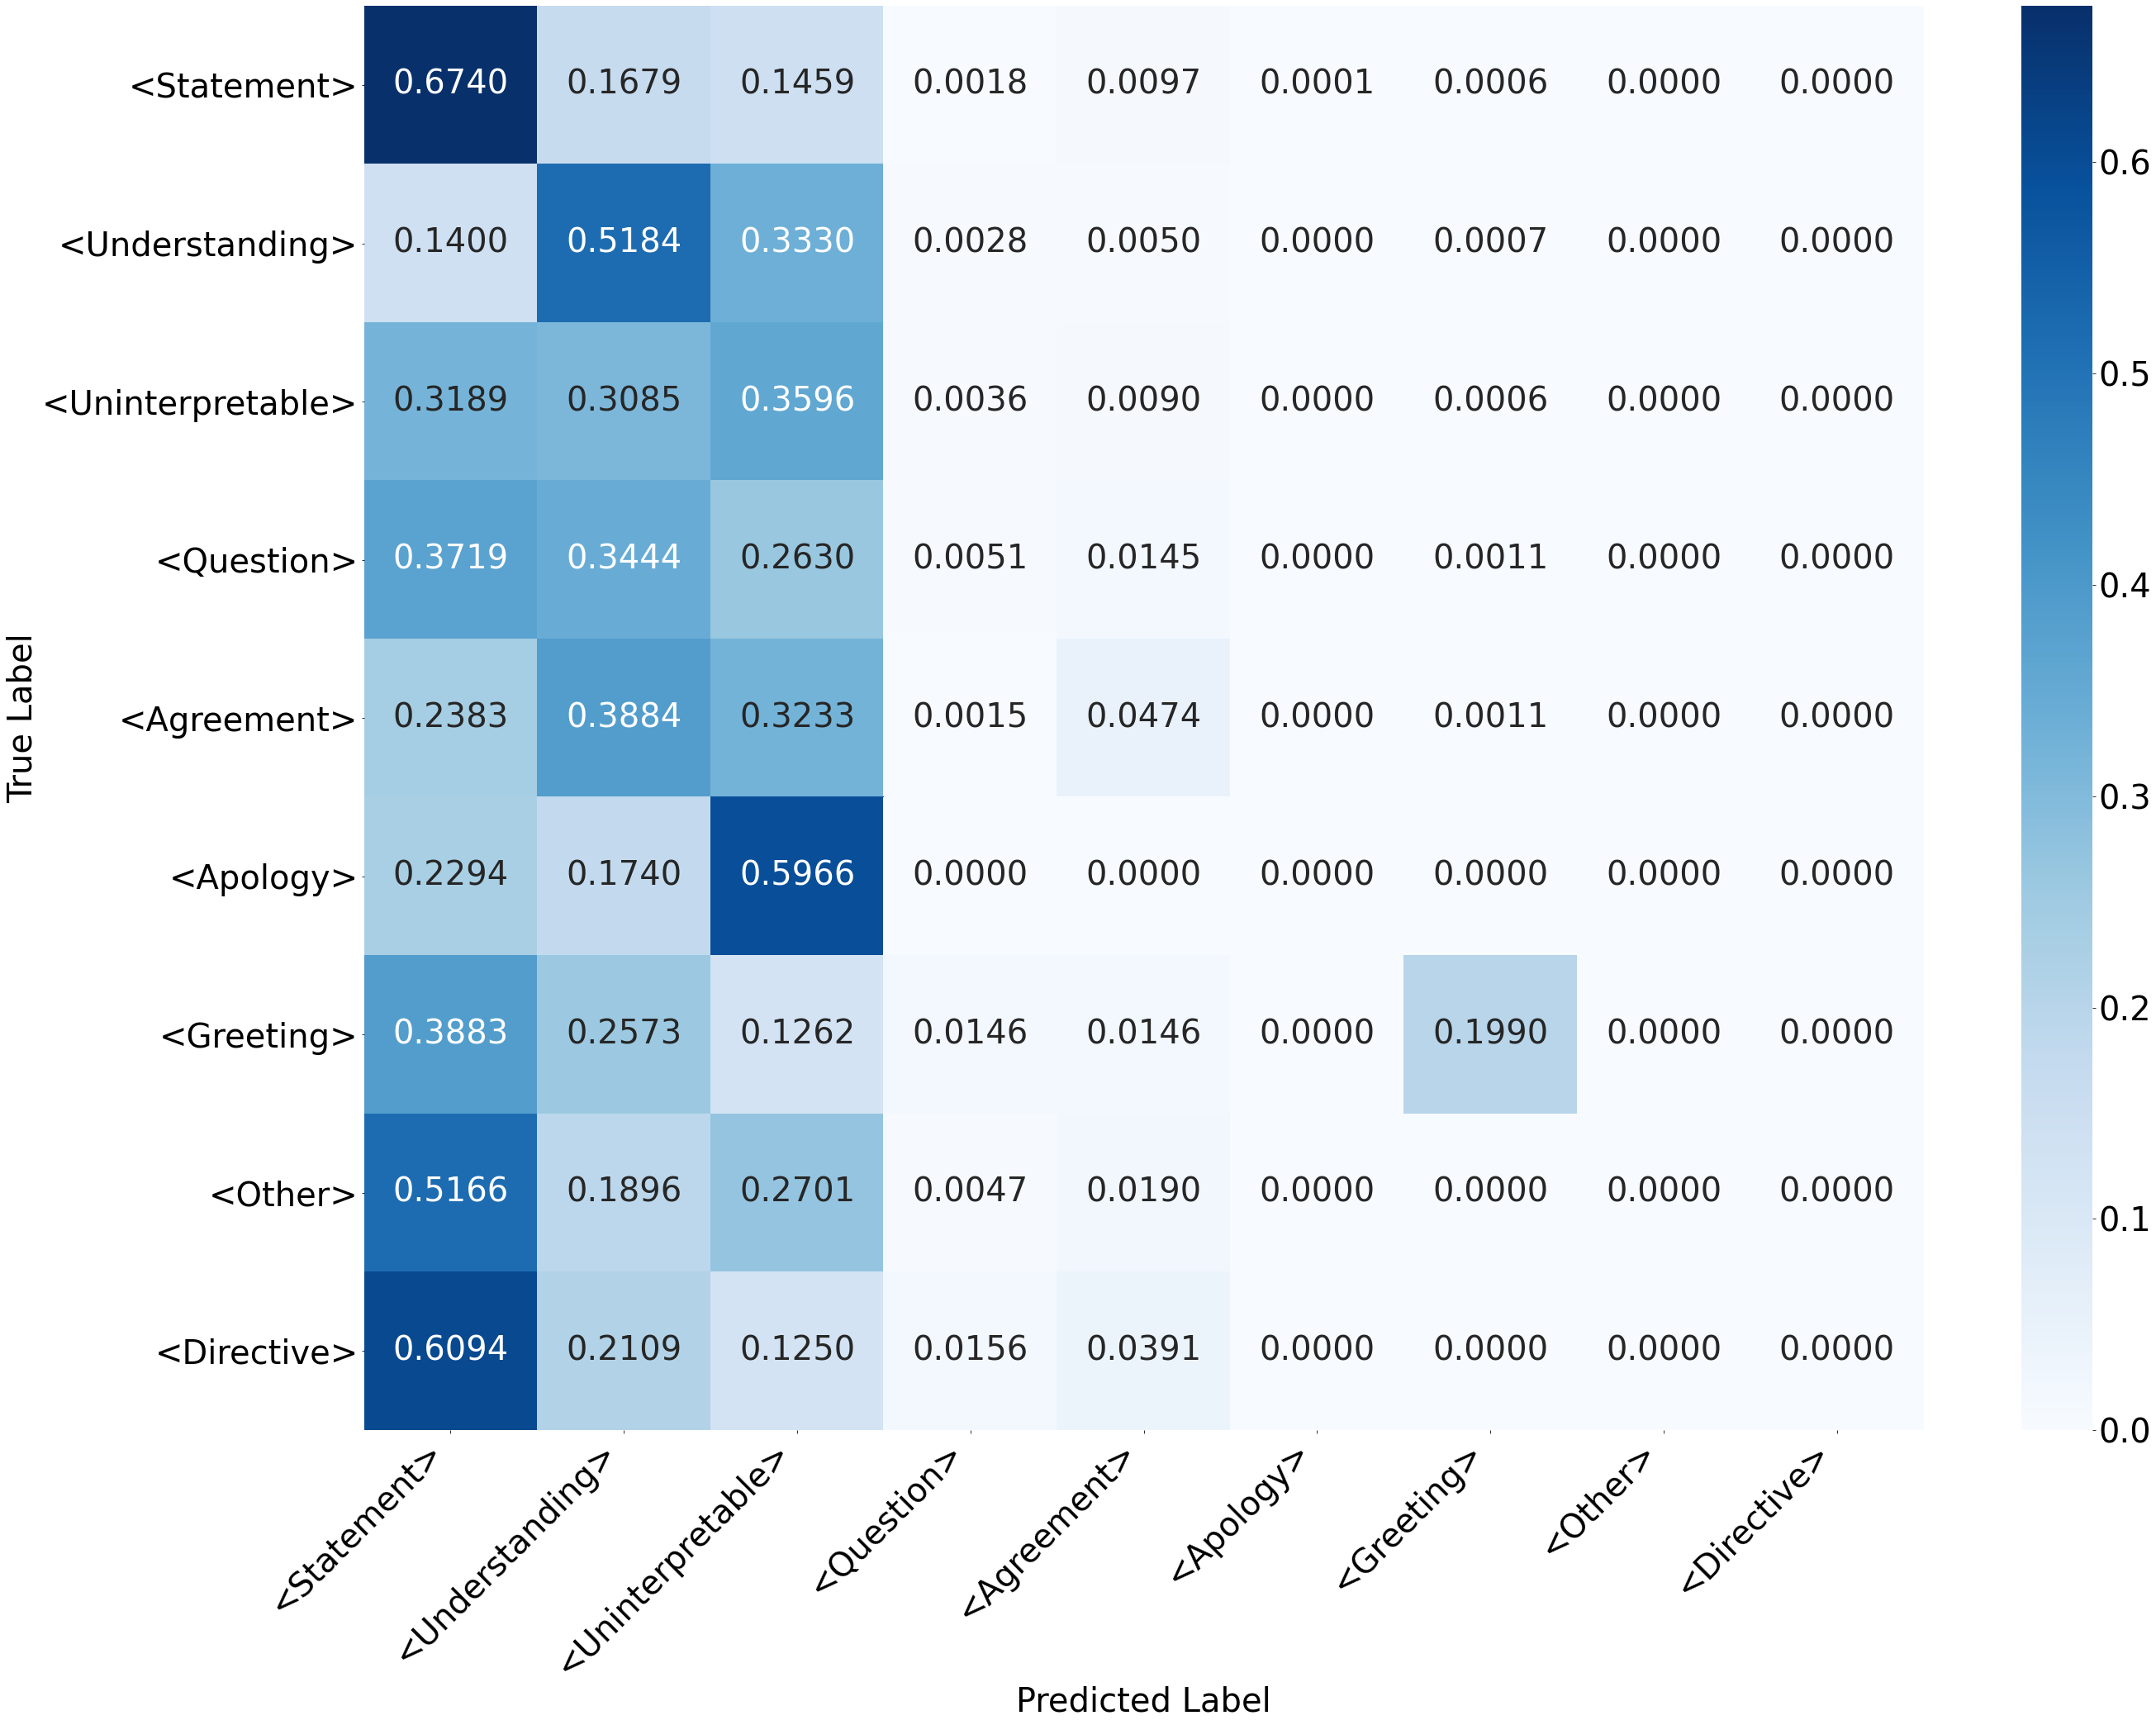

In [79]:
save_cmx(true, pred, loss_name)